# `apply_psd`-Test

This notebook is intended for experimenting with the `apply_psd()`-function used in the training sample generator. In particular, this notebook can be used to test the effects of the Butterworth-filter.

## Preliminaries

In [114]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import time

import numpy as np
import h5py

from librosa.feature import melspectrogram
from librosa import logamplitude

from matplotlib import mlab
from matplotlib import gridspec
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt

## Function Definitions

In [116]:
def make_spectrogram(strain):
    result = melspectrogram(strain, sr=4096, n_fft=1024, hop_length=64,
                            n_mels=64, fmin=10, fmax=600)
    return logamplitude(result)

In [117]:
def get_psd(real_strain, sampling_rate=4096):

    # Define some constants
    nfft = 2 * sampling_rate  # Bigger values yield better resolution?

    # Use matplotlib.mlab to calculate the PSD from the real strain
    P_xx, freqs = mlab.psd(real_strain, NFFT=nfft, Fs=sampling_rate)

    # Interpolate it linearly, so we can re-sample the spectrum arbitrarily
    psd = interp1d(freqs, P_xx)

    return psd

In [118]:
def apply_psd(signal_t, psd, sampling_rate=4096, apply_butter=True):
    """
    Take a signal in the time domain, and a precalculated Power Spectral
    Density, and color the signal according to the given PSD.

    Args:
        signal_t: A signal in time domain (i.e. a 1D numpy array)
        psd: A Power Spectral Density, e.g. calculated from the detector noise.
            Should be a function: psd(frequency)
        sampling_rate: Sampling rate of signal_t
        butter: Whether or not to apply a Butterworth filter to the data.

    Returns: color_signal_t, the colored signal in the time domain.
    """

    # First set some parameters for computing power spectra
    n = len(signal_t)
    dt = 1./sampling_rate

    # Go into Fourier (frequency) space: signal_t -> signal_f
    frequencies = np.fft.rfftfreq(n, dt)
    signal_f = np.fft.rfft(signal_t)

    # Divide by the given Power Spectral Density (PSD)
    # This is the 'whitening' = actually adding color
    color_signal_f = signal_f / (np.sqrt(psd(frequencies) / dt / 2.))

    # Go back into time space: color_signal_f -> color_signal_t
    color_signal_t = np.fft.irfft(color_signal_f, n=n)

    # In case we want to use a Butterworth-filter, here's how to do it:
    if apply_butter:
        f_low = 10
        f_high = 600
        bb, ab = butter(4, [f_low*2/4096, f_high*2/4096], btype="bandpass")
        normalization = np.sqrt((f_high - f_low) / (sampling_rate / 2))
        color_signal_t = filtfilt(bb, ab, color_signal_t) / normalization

    return color_signal_t

## Load the real strain

In [119]:
data_path = '../data/'

real_strain_file = 'H1_2017_4096.hdf5'
strain_path = os.path.join(data_path, 'strain', real_strain_file)

# Read the HDF files into numpy arrays and store them in a dict
with h5py.File(strain_path) as file:
    real_strain = np.array(file['strain/Strain'])

## Calculate the PSD for the real strain

In [120]:
psd = get_psd(real_strain)

/lustre/home/tgebhard/tf-1.0.0_gpu/lib/python3.5/site-packages/ipykernel_launcher.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


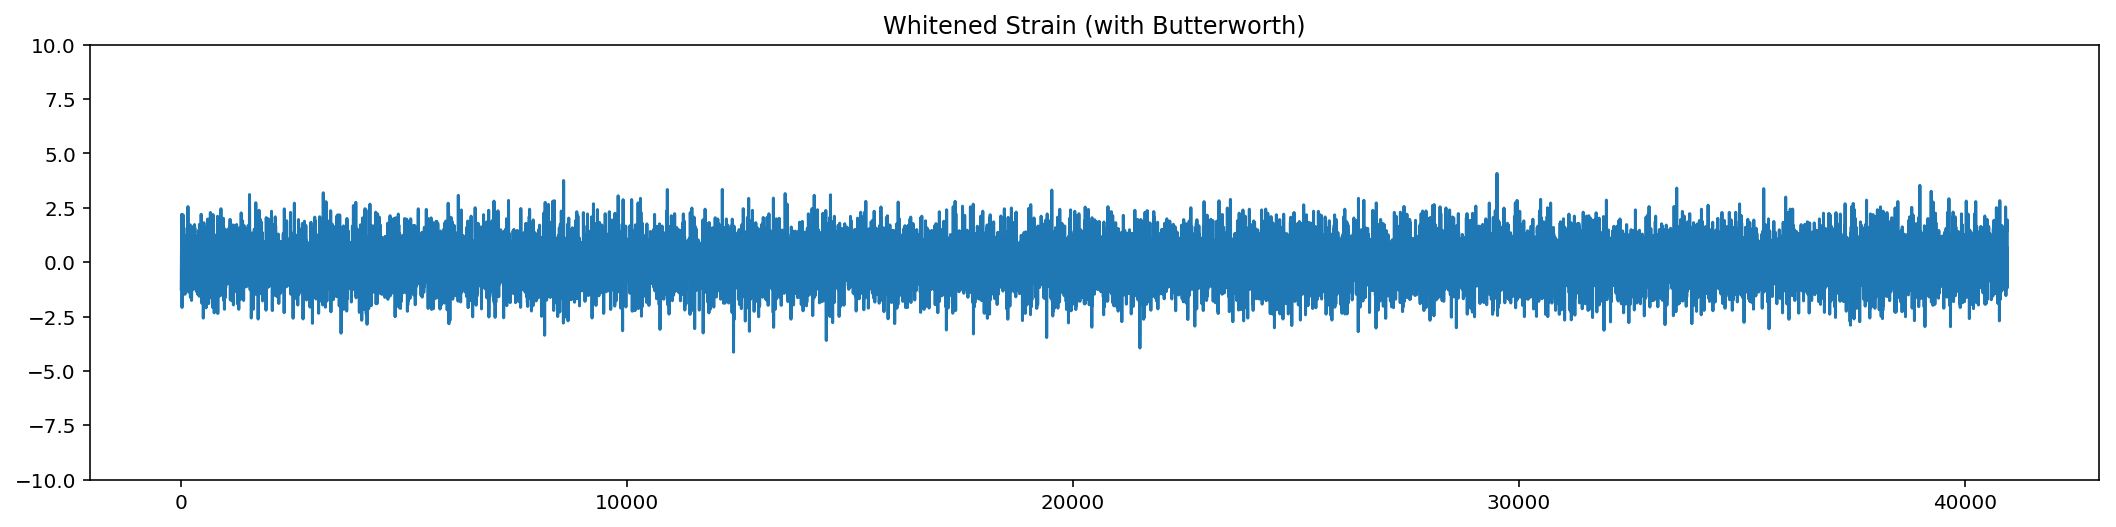

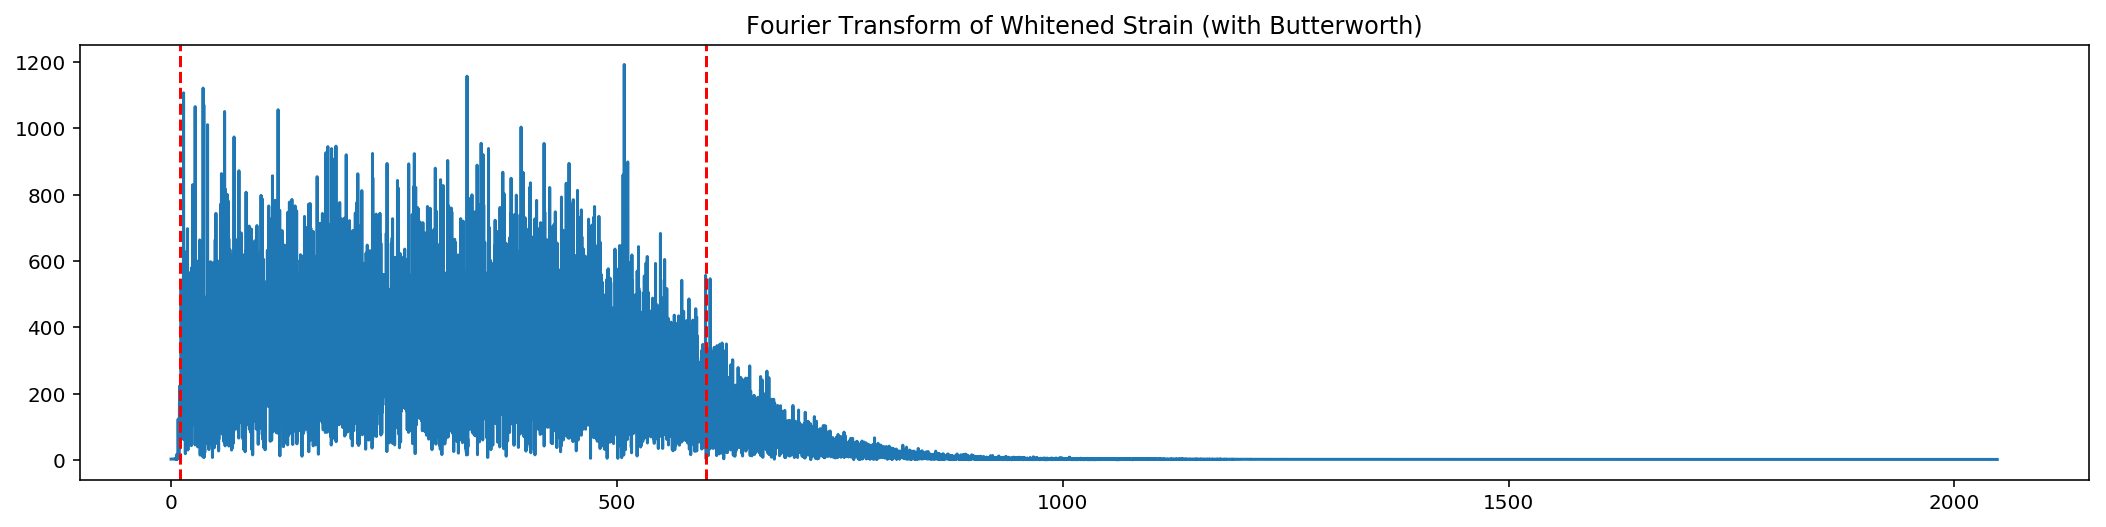

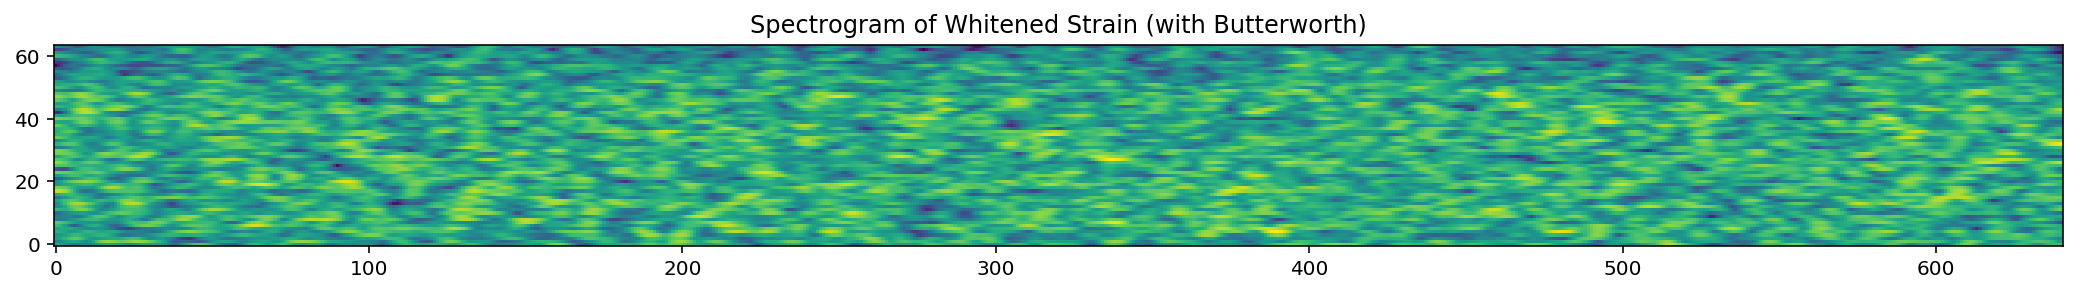

In [123]:
strain = apply_psd(real_strain[int(0*4096):int(30*4096)], psd, apply_butter=True)[int(10*4096):int(20*4096)]

spectrogram = make_spectrogram(strain)

plt.figure(1)
plt.title('Whitened Strain (with Butterworth)')
plt.plot(strain)
plt.ylim(-10, 10)
plt.gcf().set_size_inches(18, 4, forward=True)

plt.figure(2)
plt.title('Fourier Transform of Whitened Strain (with Butterworth)')
N = len(strain)/2 + 1
x = np.linspace(0, 4096/2, N, endpoint=True)
plt.plot(x, np.abs(np.fft.rfft(strain)))
plt.axvline(x=600, color='red', ls='--')
plt.axvline(x=10, color='red', ls='--')
plt.gcf().set_size_inches(18, 4, forward=True)

plt.figure(3)
plt.title('Spectrogram of Whitened Strain (with Butterworth)')
plt.imshow(spectrogram, origin="lower")
plt.gcf().set_size_inches(18, 4, forward=True)
plt.show()

/lustre/home/tgebhard/tf-1.0.0_gpu/lib/python3.5/site-packages/ipykernel_launcher.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


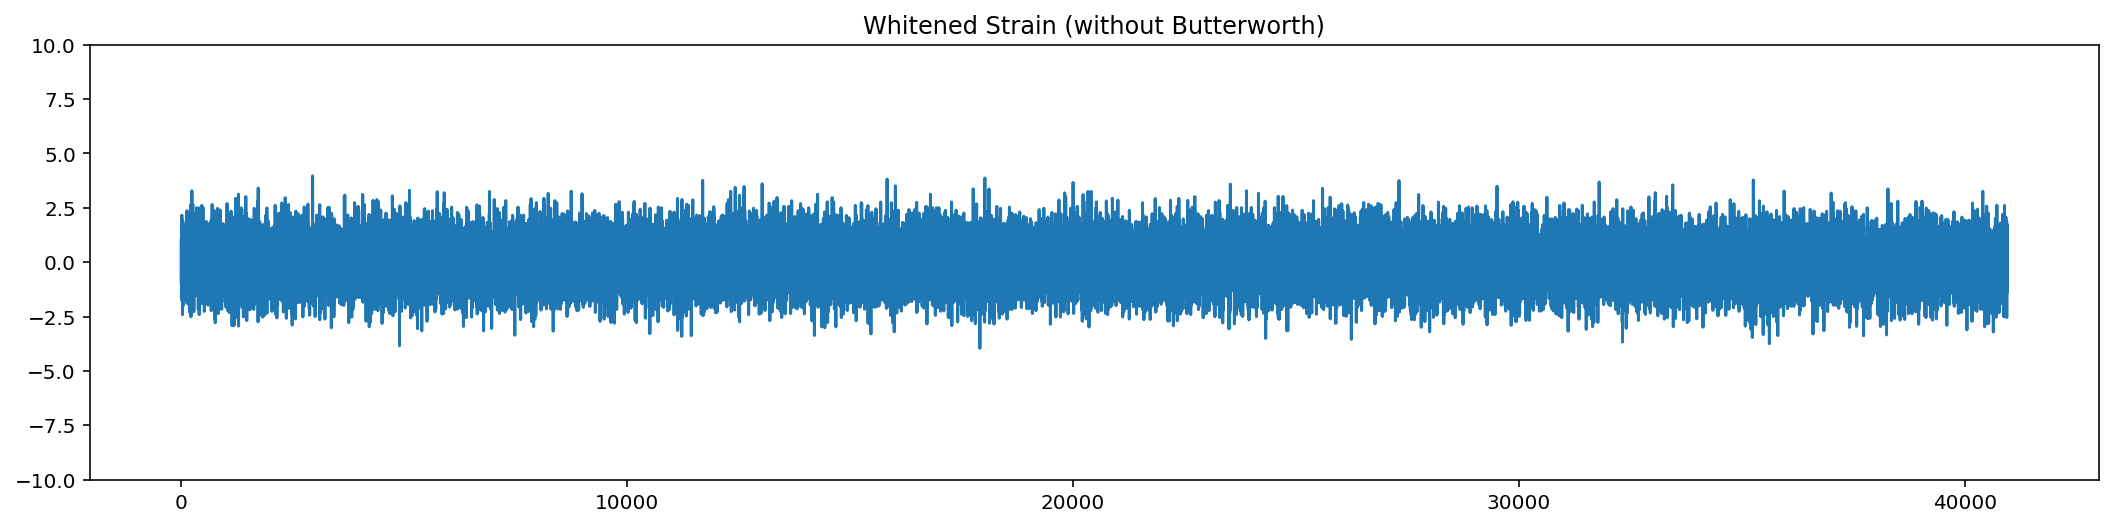

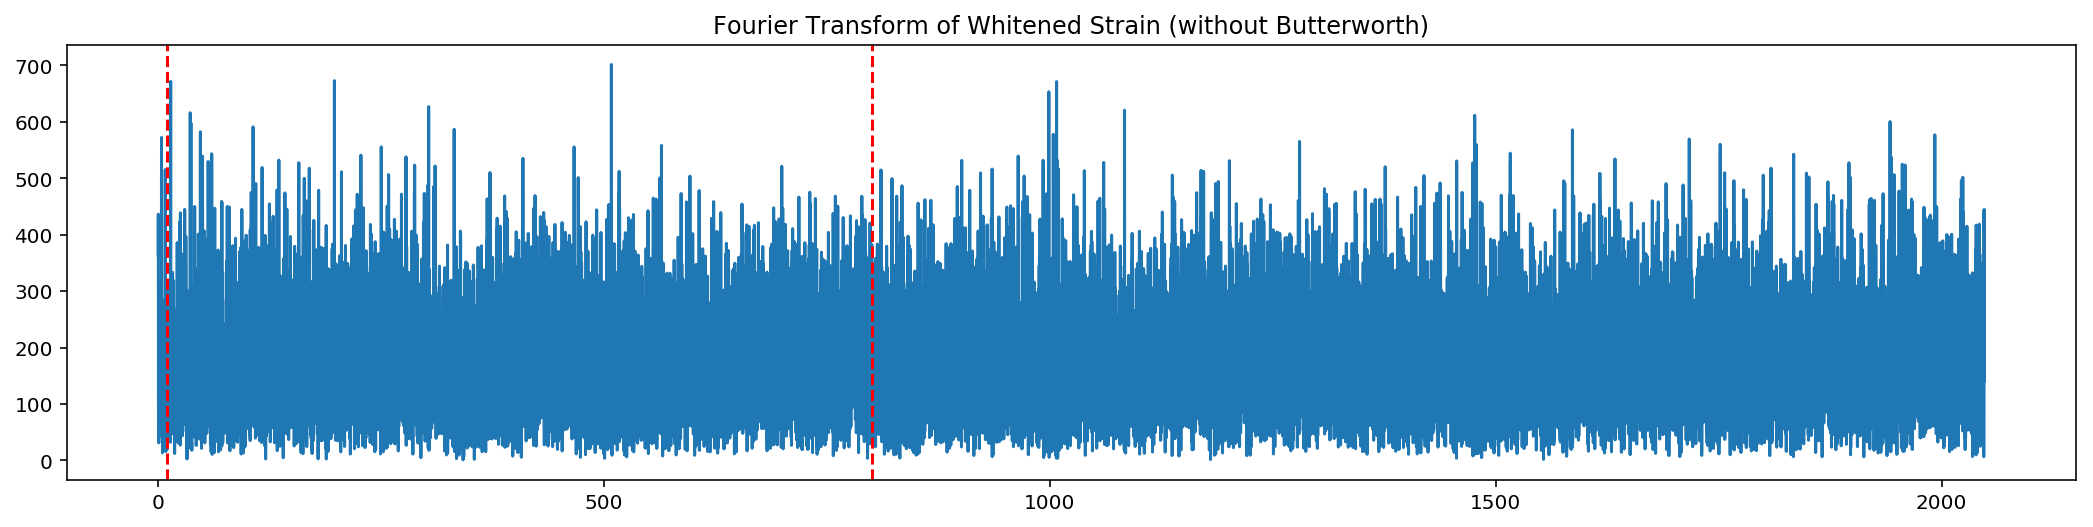

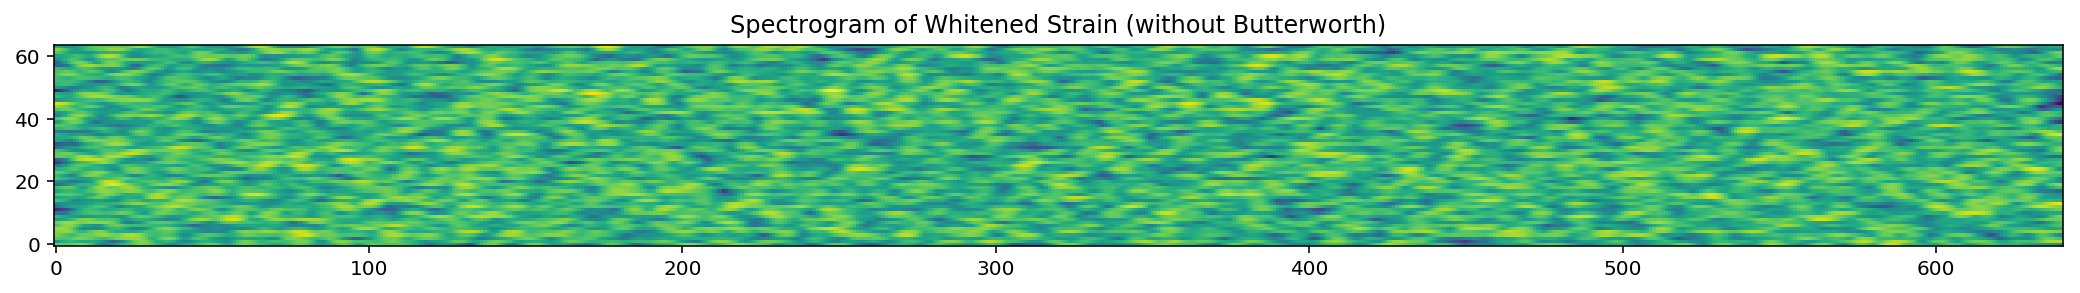

In [124]:
strain = apply_psd(real_strain[int(20*4096):int(50*4096)], psd, apply_butter=False)[int(10*4096):int(20*4096)]

spectrogram = make_spectrogram(strain)

plt.figure(1)
plt.title('Whitened Strain (without Butterworth)')
plt.plot(strain)
plt.ylim(-10, 10)
plt.gcf().set_size_inches(18, 4, forward=True)

plt.figure(2)
plt.title('Fourier Transform of Whitened Strain (without Butterworth)')
N = len(strain)/2 + 1
x = np.linspace(0, 4096/2, N, endpoint=True)
plt.plot(x, np.abs(np.fft.rfft(strain)))
plt.axvline(x=800, color='red', ls='--')
plt.axvline(x=10, color='red', ls='--')
plt.gcf().set_size_inches(18, 4, forward=True)

plt.figure(3)
plt.title('Spectrogram of Whitened Strain (without Butterworth)')
plt.imshow(spectrogram, origin="lower")
plt.gcf().set_size_inches(18, 4, forward=True)
plt.show()

# Fourier Transform of the Whitened Strains

## Read in the strains

In [158]:
real_strains = dict()
real_strain_files = {'H1': 'H1_2017_4096.hdf5', 
                     'L1': 'L1_2017_4096.hdf5'} 

for ifo in ['H1', 'L1']:
    
    strain_path = os.path.join(data_path, 'strain', real_strain_files[ifo])

    with h5py.File(strain_path) as file:
        real_strains[ifo] = np.array(file['strain/Strain'])

## Calculate PSDs and whiten the strains

In [160]:
whitened_strains = dict()
psds = dict()

for ifo in ['H1', 'L1']:
    
    # Calculate the PSD for that interferometer
    psds[ifo] = get_psd(real_strains[ifo])
    
    # Use that to whiten the strain
    whitened_strains[ifo] = apply_psd(real_strains[ifo], psds[ifo], apply_butter=False)
    
    # Cut of spectral leakage
    whitened_strains[ifo] = whitened_strains[ifo][int(10*4096):int(-10*4096)]

## Calculate the Fourier Transforms of the Whitened Strains

In [162]:
ft_strains = dict()

for ifo in ['H1', 'L1']:
    
    ft_strains[ifo] = np.abs(np.fft.rfft(whitened_strains[ifo]))

## Plot the Spectrum (Fourier Transform) of the Whitened Strains

/lustre/home/tgebhard/tf-1.0.0_gpu/lib/python3.5/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """


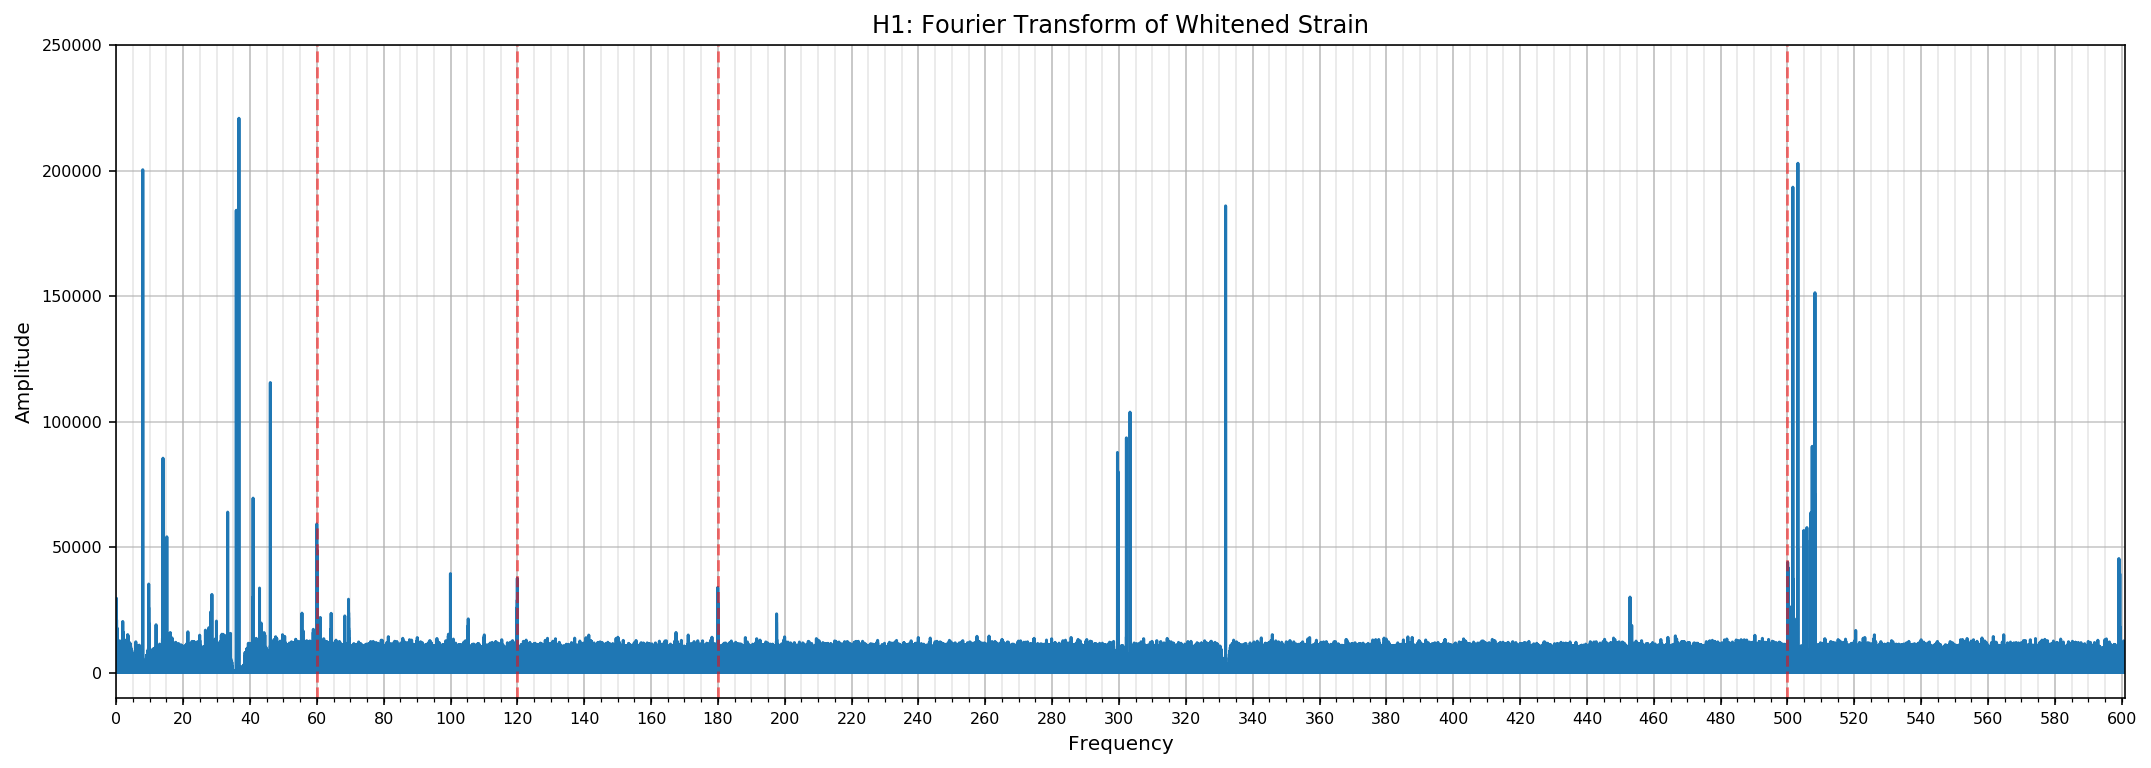

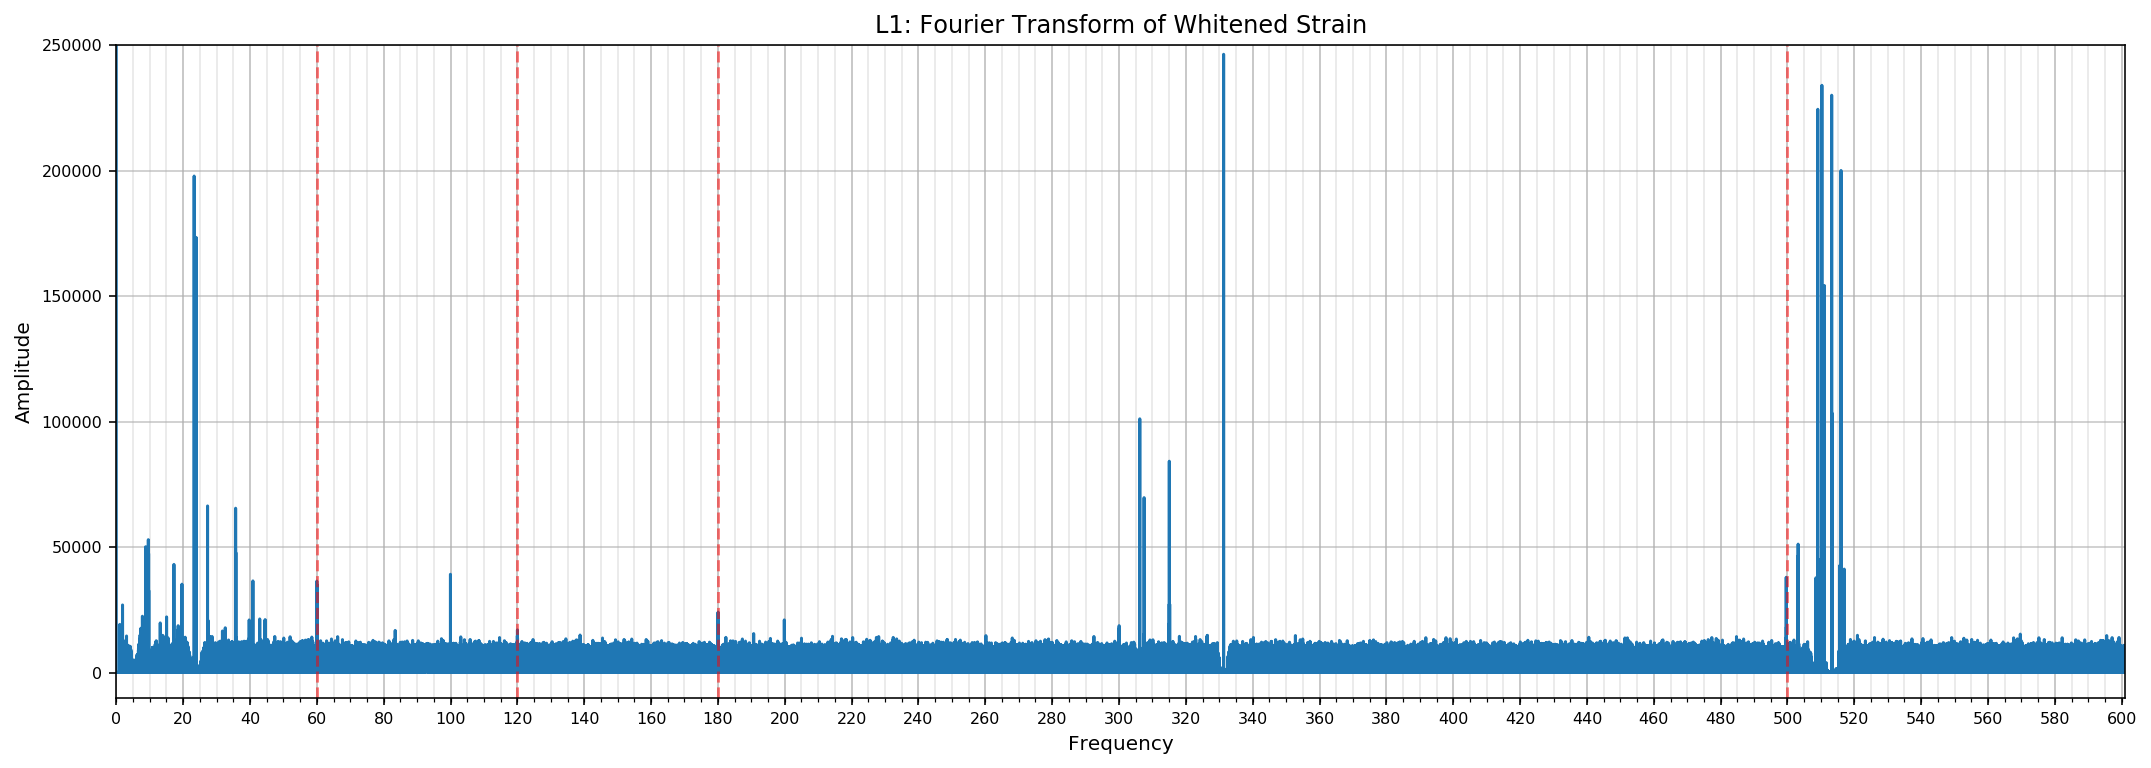

In [165]:
for ifo in ['H1', 'L1']:

    # Actually plot the spectrum
    N = len(whitened_strains[ifo])/2 + 1
    x = np.linspace(0, 4096/2, N, endpoint=True)
    plt.plot(x, ft_strains[ifo])

    # Add lines that mark calibration frequencies
    plt.axvline(x=60, color='red', ls='--', alpha=0.5)
    plt.axvline(x=120, color='red', ls='--', alpha=0.5)
    plt.axvline(x=180, color='red', ls='--', alpha=0.5)
    plt.axvline(x=500, color='red', ls='--', alpha=0.5)
    
    # Turn on some fine grid
    ax = plt.gca()
    ax.set_xlim(0, 601)
    major_xticks = np.arange(0, 601, 20)
    minor_xticks = np.arange(0, 601, 5)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 8)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 4)
    ax.set_xticks(major_xticks)
    ax.set_xticks(minor_xticks, minor = True)
    ax.tick_params(which = 'both', direction = 'out')
    ax.grid(which = 'minor', alpha = 0.3)
    ax.grid(which = 'major', alpha = 0.7)
    
    # Add title and axes labels, adjust size
    plt.title('{}: Fourier Transform of Whitened Strain'.format(ifo))
    plt.xlabel('Frequency')
    plt.ylabel('Amplitude')
    plt.ylim(-10000, 250000)
    plt.gcf().set_size_inches(18, 6, forward=True)
    
    plt.show()